In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [2]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = "../../data"
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [4]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
MSE = nn.MSELoss()
losses = []

In [6]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + (3 * KLD)

def loss_function_test(x, x_hat, mean, log_var):
    reproduction_loss = MSE(x_hat, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [8]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        print(f"Epoch [{epoch + 1}/{epochs}]\tAVG_LOSS: {overall_loss/(batch_idx*batch_size)}")
    return overall_loss

Epoch [1/20]	AVG_LOSS: 188.18699701325124
Epoch [2/20]	AVG_LOSS: 171.75033139542467
Epoch [3/20]	AVG_LOSS: 168.22724100714734
Epoch [4/20]	AVG_LOSS: 166.055495911154
Epoch [5/20]	AVG_LOSS: 164.39019624178317
Epoch [6/20]	AVG_LOSS: 163.126961439639
Epoch [7/20]	AVG_LOSS: 162.14017640077213
Epoch [8/20]	AVG_LOSS: 161.24668920857678
Epoch [9/20]	AVG_LOSS: 160.70278361070535
Epoch [10/20]	AVG_LOSS: 160.13216490374583
Epoch [11/20]	AVG_LOSS: 159.5992407919449
Epoch [12/20]	AVG_LOSS: 159.20107811521808
Epoch [13/20]	AVG_LOSS: 158.87593032658597
Epoch [14/20]	AVG_LOSS: 158.53083076285998
Epoch [15/20]	AVG_LOSS: 158.16623884860184
Epoch [16/20]	AVG_LOSS: 158.034382629904
Epoch [17/20]	AVG_LOSS: 157.65809025785163
Epoch [18/20]	AVG_LOSS: 157.51792641055405
Epoch [19/20]	AVG_LOSS: 157.1781744313439
Epoch [20/20]	AVG_LOSS: 157.0083060145816


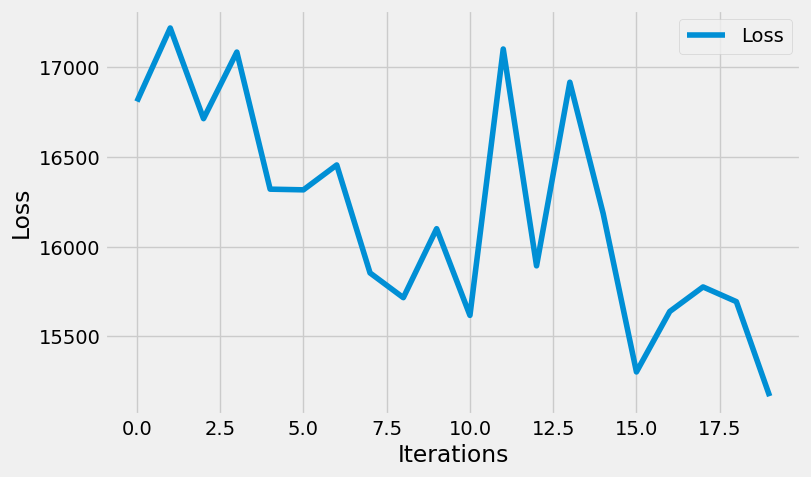

In [9]:
train(model, optimizer, epochs=20, device=device)
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

In [10]:
torch.save(model.state_dict(), "../../output/s2/based.pth")



In [ ]:
model = VAE()
model.load_state_dict(torch.load("../../output/s2/based.pth"))
model.eval

In [10]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

#img1: mean0, var1 / img2: mean1, var0
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

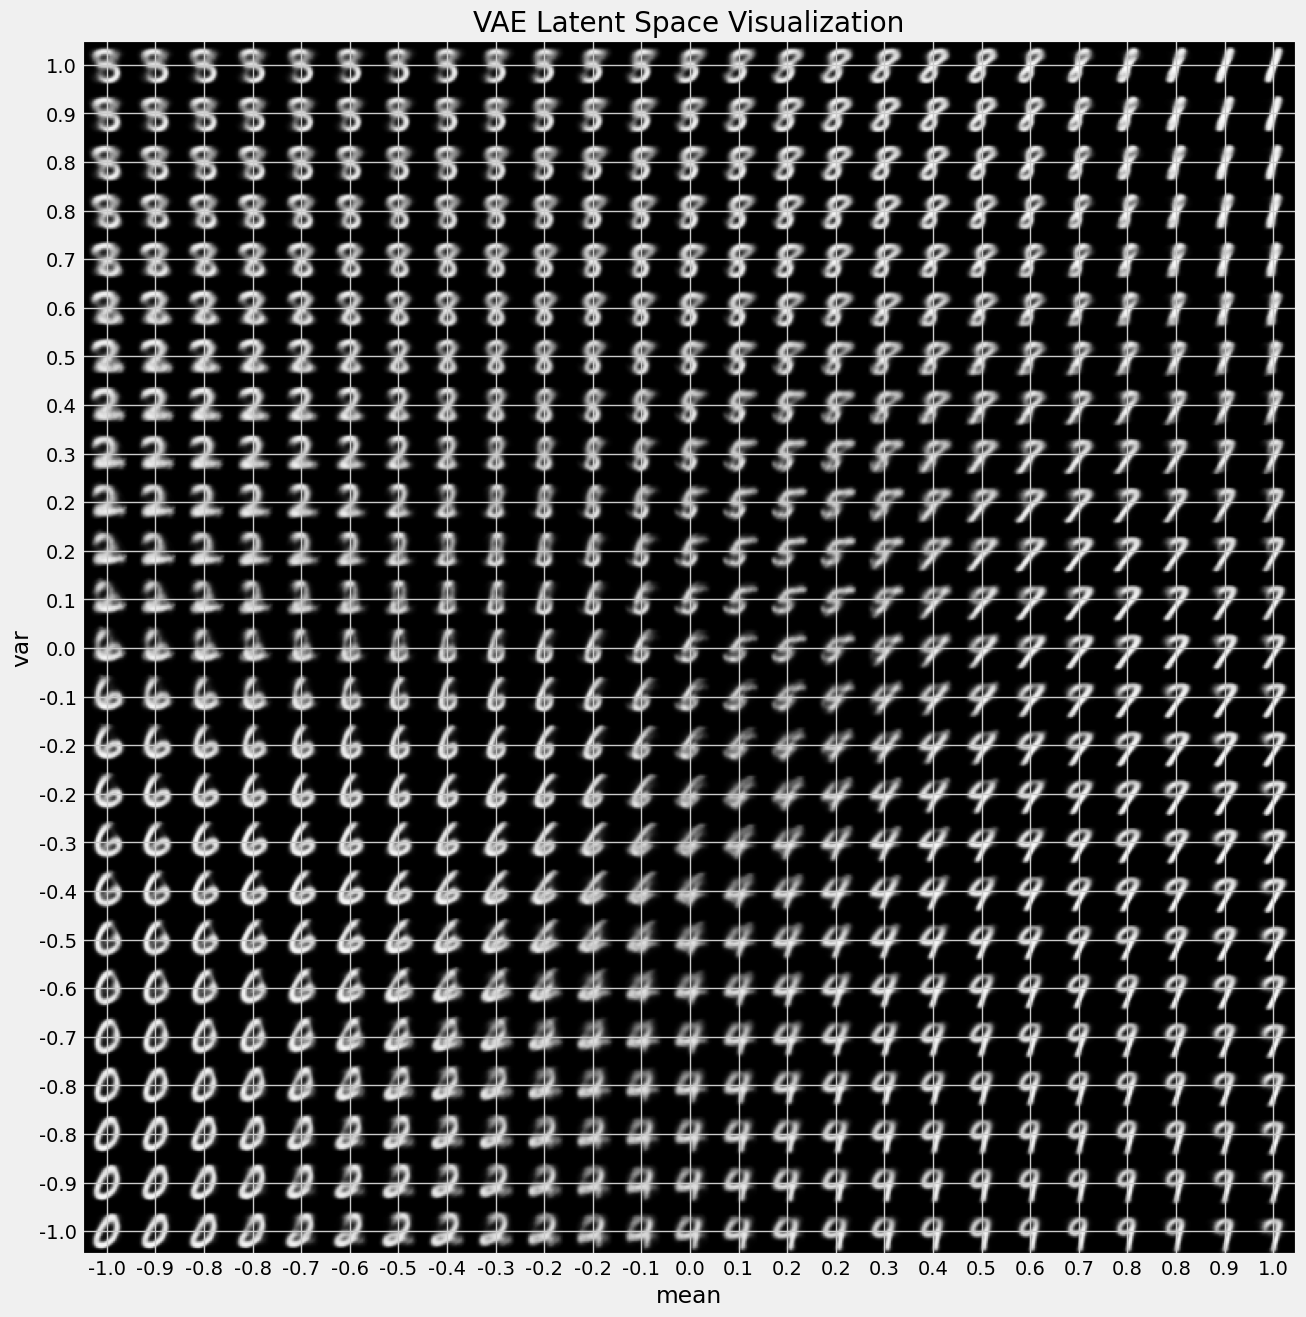

In [11]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    # print(grid_x, grid_y)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean")
    plt.ylabel("var")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(model, scale=1.0)

# Change Things a little

In [17]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function_test(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        print(f"Epoch [{epoch}/{epochs}]\tAVG_LOSS: {overall_loss/(batch_idx*batch_size)}")
    return overall_loss

Epoch [0/20]	AVG_LOSS: 0.0007921119647501706
Epoch [1/20]	AVG_LOSS: 0.0006771232544729029
Epoch [2/20]	AVG_LOSS: 0.0006761142687999545
Epoch [3/20]	AVG_LOSS: 0.0006760010693551901
Epoch [4/20]	AVG_LOSS: 0.0006756576006370713
Epoch [5/20]	AVG_LOSS: 0.0006754464531730929
Epoch [6/20]	AVG_LOSS: 0.0006753906472049691
Epoch [7/20]	AVG_LOSS: 0.0006749802475207437
Epoch [8/20]	AVG_LOSS: 0.000674889714819362
Epoch [9/20]	AVG_LOSS: 0.0006747623745084605
Epoch [10/20]	AVG_LOSS: 0.0006746130289264234
Epoch [11/20]	AVG_LOSS: 0.0006743870516352741
Epoch [12/20]	AVG_LOSS: 0.0006743515504272234
Epoch [13/20]	AVG_LOSS: 0.0006743655629294344
Epoch [14/20]	AVG_LOSS: 0.0006742602357258382
Epoch [15/20]	AVG_LOSS: 0.0006742636786030608
Epoch [16/20]	AVG_LOSS: 0.0006742092723863352
Epoch [17/20]	AVG_LOSS: 0.0016140738501522894
Epoch [18/20]	AVG_LOSS: 0.0006793978324592213
Epoch [19/20]	AVG_LOSS: 0.0006783634746363247


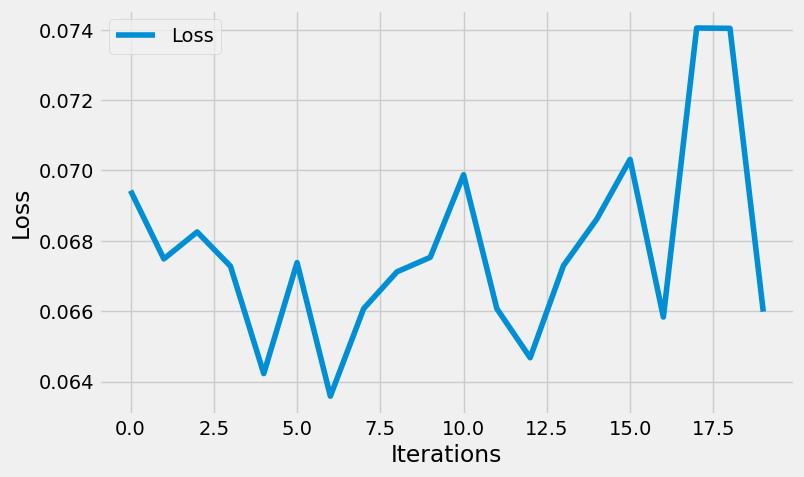

In [20]:
train(model, optimizer, epochs=20, device=device)
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

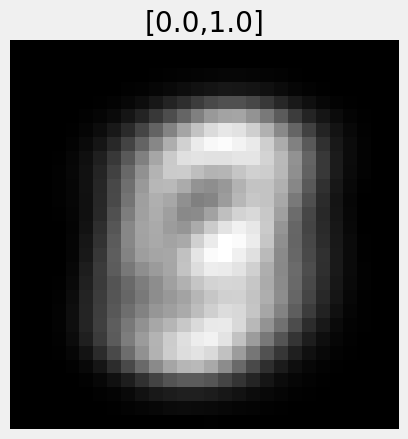

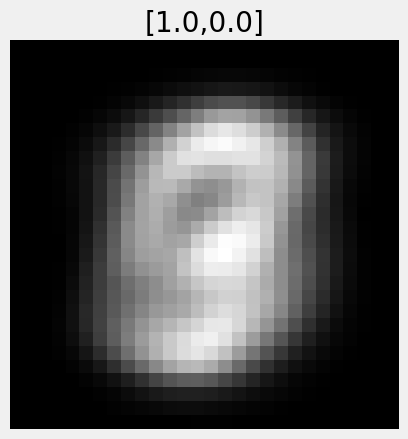

(None, None)

In [21]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

#img1: mean0, var1 / img2: mean1, var0
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

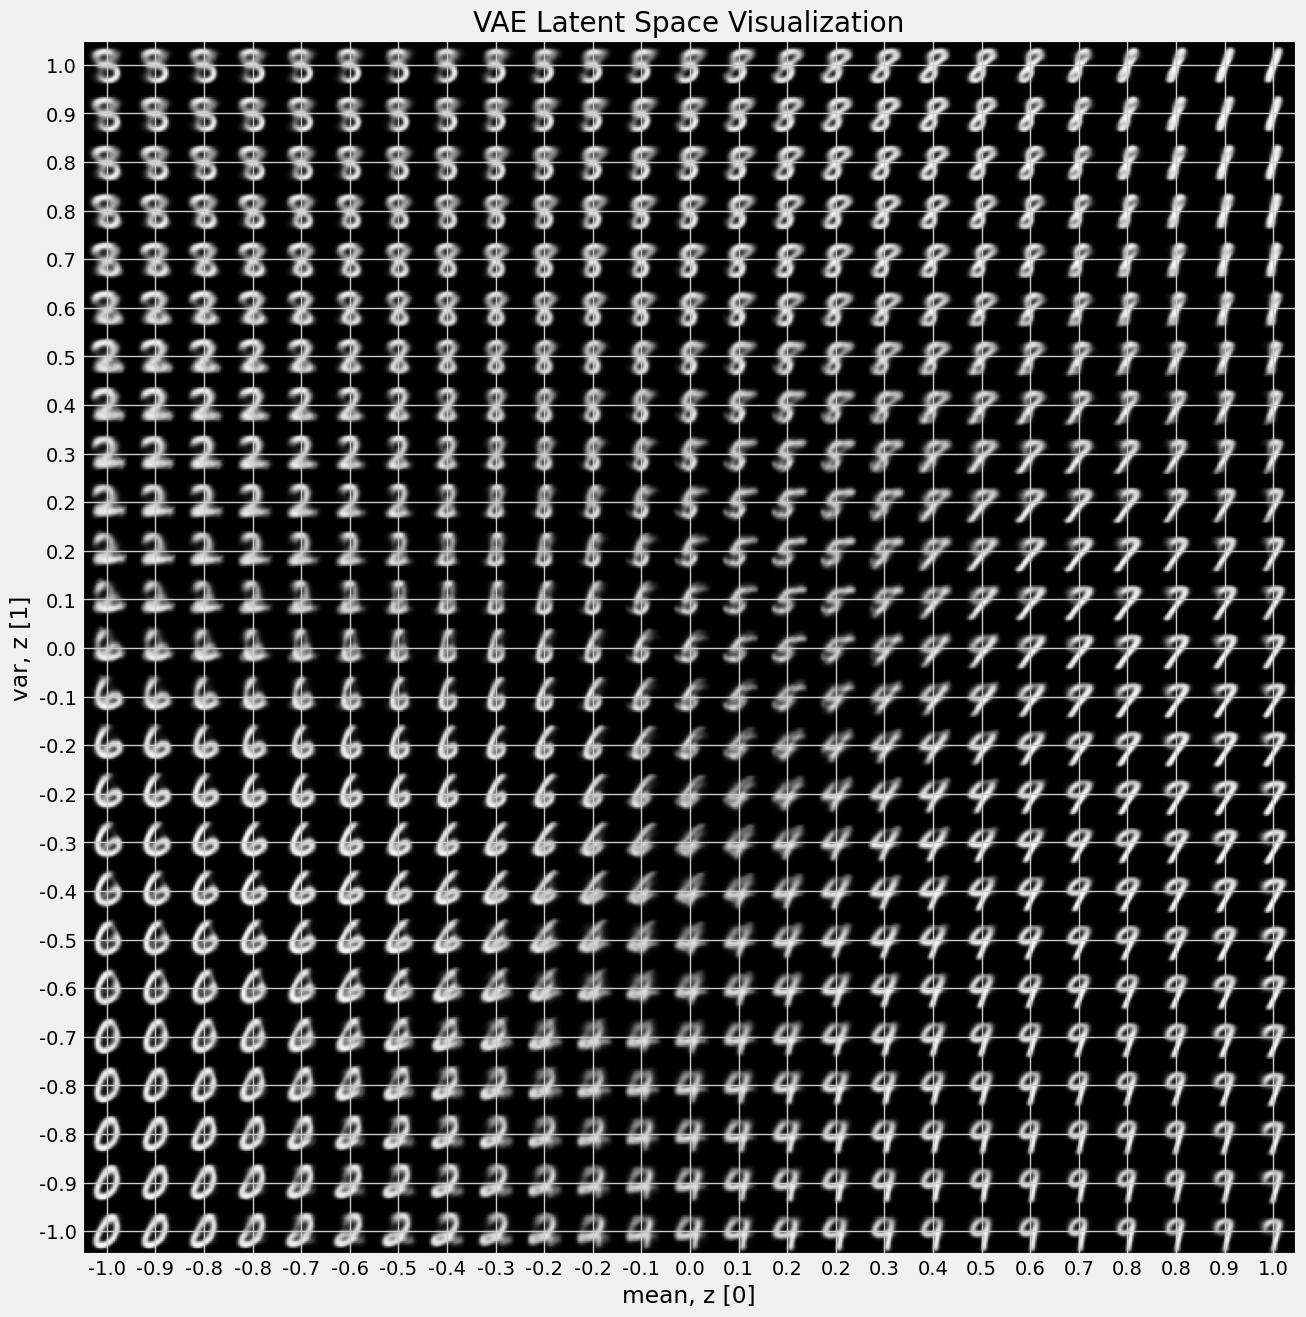

In [ ]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(model, scale=1.0)

In [ ]:
from sklearn.decomposition import PCA

def plot_latent_projection(model: VAE):
    model.eval()
    dataloader = test_loader
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.view(images.size(0), -1).to(device)
            mu, _ = model.encode(images)
            all_mu.append(mu.cpu())
            all_labels.append(labels)
    latent = torch.cat(all_mu, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()

    latent_2d = PCA(n_components=2).fit_transform(latent)
    _, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(
        latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="tab10", s=10, alpha=0.7
    )
    # ax.grid(True, linestyle='--', alpha=0.5)
    # ax.spines['left'].set_position('zero')
    # ax.spines['bottom'].set_position('zero')
    plt.colorbar(scatter, label="Label ID")
    plt.xlabel("latend_2d[:, 0]")
    plt.ylabel("latend_2d[:, 1]")
    plt.title("Latent space visualization")
    plt.show()

plot_latent_projection(model)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2800x28 and 784x400)